<a href="https://colab.research.google.com/github/krishnaaa-7/Smart-Claims-Processing-Platform_hidevs/blob/main/smartclaimsprocessingplatformm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
!sudo apt install tesseract-ocr -y > /dev/null
!pip install pytesseract transformers huggingface_hub --quiet


In [106]:
from huggingface_hub import login
from transformers import pipeline
import pytesseract
from PIL import Image
import os

# Log in with your Hugging Face token (stored as secret or hardcoded for now)
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN') # Use your token here

In [108]:
login(token=hf_token)

In [109]:
from google.colab import files
uploaded = files.upload()  # Upload a claim image (jpg/png)

file_name = next(iter(uploaded))
img = Image.open(file_name)
text = pytesseract.image_to_string(img)
print("📄 Extracted Text:\n", text)


Saving sample_claim_form.png to sample_claim_form (4).png
📄 Extracted Text:
 CLAIM FoR Mane: John Doe Date: 2025-07-20 Description of Incident: While
parking ny vehicle on 18th July 2025, another car reay-ended ny vehicle causing
‘Significant danage to the rear bumper. The accident took place near EIn street,
and a police report has been filed. Clain snout Requested: $1,500 Policy
umber: nUro-4522-¥Y



In [110]:
# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Labels you want to classify against
labels = ["Auto Claim", "Health Claim", "Property Claim", "Travel Claim"]

# Perform classification
result = classifier(text, candidate_labels=labels)
claim_type = result["labels"][0]

print(" Predicted Claim Type:", claim_type)


Device set to use cpu


 Predicted Claim Type: Auto Claim


In [111]:
def route_claim(claim_type, text):
    text_lower = text.lower()
    if "urgent" in text_lower or "accident" in text_lower:
        return "🚨 Urgent Queue – Escalate Immediately"
    if claim_type == "Auto Claim" and "collision" in text_lower:
        return "🚗 Route to Collision Specialist"
    elif claim_type == "Health Claim" and "surgery" in text_lower:
        return "🏥 Route to Surgical Review Team"
    elif claim_type == "Property Claim" and "fire" in text_lower:
        return "🔥 Route to Fire Damage Team"
    else:
        return f"📥 General Routing for: {claim_type}"


In [112]:
import json

policy_rules_content = {
  "exclusions": {
    "alcohol": "Alcohol-related incident",
    "fraud": "Potential fraudulent claim",
    "expired policy": "Policy no longer active",
    "intentional damage": "Self-inflicted or deliberate loss"
  },
  "limits": {
    "max_amount": "1,00,000"
  }
}

with open("policy_rules.json", "w") as f:
    json.dump(policy_rules_content, f, indent=2)

print("✅ policy_rules.json created successfully.")

✅ policy_rules.json created successfully.


In [113]:
import json

# Load policy rules from JSON
with open("policy_rules.json", "r") as f:
    policy = json.load(f)

def check_policy_exclusions(text):
    exclusions = policy["exclusions"]
    for term, reason in exclusions.items():
        if term.lower() in text.lower():
            return f"❌ Rejected: {reason} ({term})"

    # Limit validation (simplified)
    if "₹" in text and policy["limits"]["max_amount"] in text:
        return "⚠️ Amount exceeds policy coverage – Manual Review"

    return "✅ Passed Compliance"



In [114]:
def check_policy_compliance(text):
    exclusions = ["pre-existing", "non-covered", "expired", "excluded"]
    for word in exclusions:
        if word in text.lower():
            return "❌ Policy Violation: Check for exclusions"
    return "✅ Compliant with standard policy"


In [115]:
def check_policy_compliance(text, rules):
    violations = []
    for keyword, reason in rules["exclusions"].items():
        if keyword.lower() in text.lower():
            violations.append(f"❌ {reason}")
    if not violations:
        return "✅ No policy violations found."
    return "\n".join(violations)

with open("policy_rules.json") as f:
    rules = json.load(f)
compliance_result = check_policy_compliance(text, rules)



In [116]:
from datetime import datetime
print("🕒 Time Processed:", datetime.now())


🕒 Time Processed: 2025-07-20 07:23:15.625814


/tmp/ipython-input-117-1987297157.py:13: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


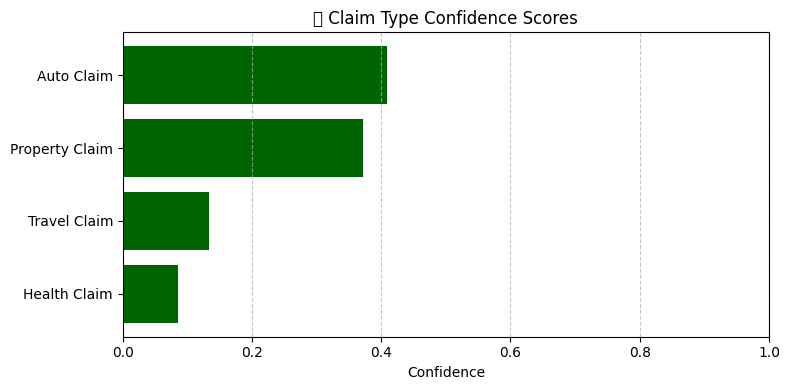

In [117]:
import matplotlib.pyplot as plt

# Plot classification confidence scores
labels = result["labels"]
scores = result["scores"]

plt.figure(figsize=(8, 4))
plt.barh(labels[::-1], scores[::-1], color='darkgreen')
plt.xlabel("Confidence")
plt.title("🧠 Claim Type Confidence Scores")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [118]:
import csv
from datetime import datetime

# Define the CSV file name
csv_filename = "claim_logs.csv"

# Prepare data to log
log_row = [
    datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    claim_type,
    routing,
    compliance_result,
    text.replace('\n', ' ')[:100]  # Shortened claim text
]

# Write to CSV (append mode)
with open(csv_filename, mode='a', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(log_row)

print(f"✅ Result logged to {csv_filename}")


✅ Result logged to claim_logs.csv


In [119]:
{
  "exclusions": {
    "alcohol": "Alcohol-related incident",
    "fraud": "Potential fraudulent claim",
    "expired policy": "Policy no longer active",
    "intentional damage": "Self-inflicted or deliberate loss"
  },
  "limits": {
    "max_amount": "1,00,000"
  }
}


{'exclusions': {'alcohol': 'Alcohol-related incident',
  'fraud': 'Potential fraudulent claim',
  'expired policy': 'Policy no longer active',
  'intentional damage': 'Self-inflicted or deliberate loss'},
 'limits': {'max_amount': '1,00,000'}}

In [120]:
print("\n======FINAL RESULT======")
print("Extracted Text:\n", text)
print("Claim Type:", claim_type)
print("Routing Decision:", routing)
print("Policy Compliance Check:\n", compliance_result)
print("Compliance Result:", compliance_result)



======FINAL RESULT======
Extracted Text:
 CLAIM FoR Mane: John Doe Date: 2025-07-20 Description of Incident: While
parking ny vehicle on 18th July 2025, another car reay-ended ny vehicle causing
‘Significant danage to the rear bumper. The accident took place near EIn street,
and a police report has been filed. Clain snout Requested: $1,500 Policy
umber: nUro-4522-¥Y

Claim Type: Auto Claim
Routing Decision: 🚗 Route to Auto Dept
Policy Compliance Check:
 ✅ No policy violations found.
Compliance Result: ✅ No policy violations found.
